### Imports

In [1]:
import numpy as np
import pandas as pd

import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from xgboost.sklearn import XGBRegressor

import torch

import jax
import jax.numpy as jnp

from tqdm.notebook import tqdm

import plotly.express as px

import timeit
from functools import partial
from typing import Callable

## Automatic Differentiation

### PyTorch

In [2]:
def torch_sle_loss(y_true: torch.Tensor, y_pred: torch.Tensor):
    """Calculate the Squared Log Error loss."""
    return 1/2 * (torch.log1p(y_pred) - torch.log1p(y_true))**2

def torch_autodiff_grad_hess(
    loss_function: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    y_true: np.ndarray, y_pred: np.ndarray
):
    """Perform automatic differentiation to get the
    Gradient and the Hessian of `loss_function`."""
    y_true = torch.tensor(y_true, dtype=torch.float, requires_grad=False)
    y_pred = torch.tensor(y_pred, dtype=torch.float, requires_grad=True)
    loss_function_sum = lambda y_pred: loss_function(y_true, y_pred).sum()

    loss_function_sum(y_pred).backward()
    grad = y_pred.grad

    hess_matrix = torch.autograd.functional.hessian(loss_function_sum, y_pred, vectorize=True)
    hess = torch.diagonal(hess_matrix)

    return grad, hess

### JAX

In [3]:
def jax_sle_loss(y_true: np.ndarray, y_pred: np.ndarray):
    """Calculate the Squared Log Error loss."""
    return (1/2 * (jnp.log1p(y_pred) - jnp.log1p(y_true))**2)

def hvp(f, inputs, vectors):
    """Hessian-vector product."""
    return jax.jvp(jax.grad(f), inputs, vectors)[1]

def jax_autodiff_grad_hess(
    loss_function: Callable[[np.ndarray, np.ndarray], np.ndarray],
    y_true: np.ndarray, y_pred: np.ndarray
):
    """Perform automatic differentiation to get the
    Gradient and the Hessian of `loss_function`."""
    loss_function_sum = lambda y_pred: loss_function(y_true, y_pred).sum()

    grad_fn = jax.grad(loss_function_sum)
    grad = grad_fn(y_pred)

    hess = hvp(loss_function_sum, (y_pred,), (jnp.ones_like(y_pred), ))

    return grad, hess

# Benchmark

### Basic Benchmark

In [4]:
X, y = sklearn.datasets.fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.05, random_state=0)
print(f"Train Data: {X_train.shape[0]} examples, {X_train.shape[1]} features")

Train Data: 1032 examples, 8 features


In [5]:
%%timeit
jax_objective = jax.jit(partial(jax_autodiff_grad_hess, jax_sle_loss))
reg = XGBRegressor(objective=jax_objective, n_estimators=100)
reg.fit(X_train, y_train)

1.79 s ± 26.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%%timeit
torch_objective = partial(torch_autodiff_grad_hess, torch_sle_loss)
reg = XGBRegressor(objective=torch_objective, n_estimators=100)
reg.fit(X_train, y_train)

1.33 s ± 23.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Full Benchmark

In [7]:
torch_objective = partial(torch_autodiff_grad_hess, torch_sle_loss)
jax_objective = jax.jit(partial(jax_autodiff_grad_hess, jax_sle_loss))

In [8]:
def run_benchmark():
    VERBOSE = 0
    TIMEIT_NUMBER = 5
    N_ESTIMATORS = 10
    N_SAMPLES_OPTIONS = [100, 1000, 2000, 5000, 10000, 20000]

    def run_torch():
        print(f"Running torch with {len(X_train)} training examples.") if VERBOSE else None
        reg = XGBRegressor(objective=torch_objective, n_estimators=N_ESTIMATORS)
        reg.fit(X_train, y_train)
    
    def run_jax():
        print(f"Running jax with {len(X_train)} training examples.") if VERBOSE else None
        reg = XGBRegressor(objective=jax_objective, n_estimators=N_ESTIMATORS)
        reg.fit(X_train, y_train)

    def run_manual():
        reg = XGBRegressor(objective='reg:squaredlogerror', n_estimators=N_ESTIMATORS)
        reg.fit(X_train, y_train)

    entries = []
    for n_samples in tqdm(N_SAMPLES_OPTIONS):
        entry = {'n_samples': n_samples}
        X_train, y_train = resample(X, y, n_samples=n_samples)
    
        entry['torch'] = timeit.timeit(run_torch, number=TIMEIT_NUMBER) / TIMEIT_NUMBER
        entry['jax'] = timeit.timeit(run_jax, number=TIMEIT_NUMBER) / TIMEIT_NUMBER
        entry['manual'] = timeit.timeit(run_manual, number=TIMEIT_NUMBER) / TIMEIT_NUMBER

        entries.append(entry)
    entries = pd.DataFrame(entries)
    return entries

In [9]:
benchmark_results_df = run_benchmark()

  0%|          | 0/6 [00:00<?, ?it/s]

### Plotting

In [16]:
plot_df = benchmark_results_df.melt(id_vars=['n_samples'], value_vars=['torch', 'jax', 'manual'],
                                    value_name='time', var_name='implementation')
plot_df = plot_df[(plot_df['implementation'] != 'manual') & (plot_df['n_samples'] >= 2000)]
plot_df = plot_df.replace({'implementation': {'torch': 'PyTorch', 'jax': 'JAX', 'manual': 'Manual'}})

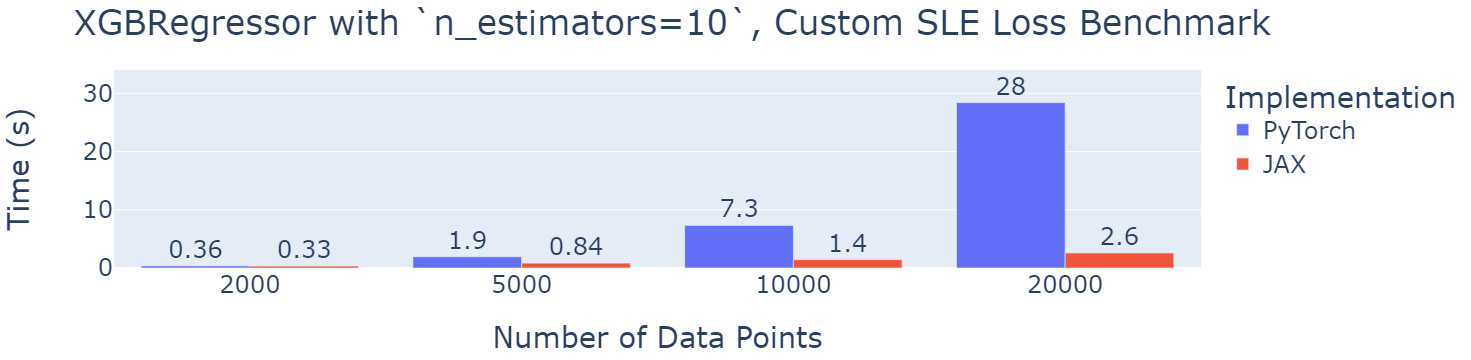

In [17]:
fig = px.bar(plot_df, x='n_samples', y='time', color='implementation',
             barmode='group', text='time', text_auto='.2',
             labels=dict(
                 time='Time (s)',
                 implementation='Implementation',
                 n_samples='Number of Data Points'))
fig.update_xaxes(type='category', title_standoff=30)
fig.update_yaxes(title_standoff=50)
fig.update_traces(textposition="outside")
fig.update_layout(font=dict(size=24), yaxis_range=[0, 34], margin=dict(t=70))
fig.update_layout(title_text='XGBRegressor with `n_estimators=10`, Custom SLE Loss Benchmark')